# Predicting Insurance Costs

For this guided project, we'll be looking at the Medical Cost Data Set from Kaggle. This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

For my regression problem, I'm interested in how these different characteristics relate to the total medical cost. It's a continuous, positive number, which makes it a good candidate for a linear regression. For this guided project, I want to construct the best possible predictive model for the cost, given some information about the patient. Predicting medical costs is an important task because it allows hospitals to predict revenue and plan necessary procedures needed by its patient population.

Let's get started!

## Introduction

In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [23]:
insurance = pd.read_csv("insurance.csv")
print(insurance.shape)


(1338, 7)


In [24]:
insurance.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

We have 1338 inputs, 6 features and 1 outcome
- 3 Continuous features : age, bmi, children
- 3 Categorical features : sex, smoker, region
- 1 Continuous outcome : charges

In [50]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   log_charges       1338 non-null   float64
 5   sex_male          1338 non-null   uint8  
 6   smoker_yes        1338 non-null   uint8  
 7   region_northwest  1338 non-null   uint8  
 8   region_southeast  1338 non-null   uint8  
 9   region_southwest  1338 non-null   uint8  
dtypes: float64(3), int64(2), uint8(5)
memory usage: 58.9 KB


So cool. Data are clean, we have no null value within our dataset.

In [25]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


- Regarding the features, we do not have any extreme value. Therefore, we do not need to normalize any of them.
- Note that Body Mass Index (BMI) is a person’s weight in kilograms (or pounds) divided by the square of height in meters (or feet). 

## Exploring The Dataset

We have 3 categorical features. To get them involved in our linear regression model, we need to convert them into dummies

In [40]:
 insurance = pd.get_dummies(insurance, ["sex", "smoker", "region"], drop_first = True)


array([[<AxesSubplot:title={'center':'charges'}>]], dtype=object)

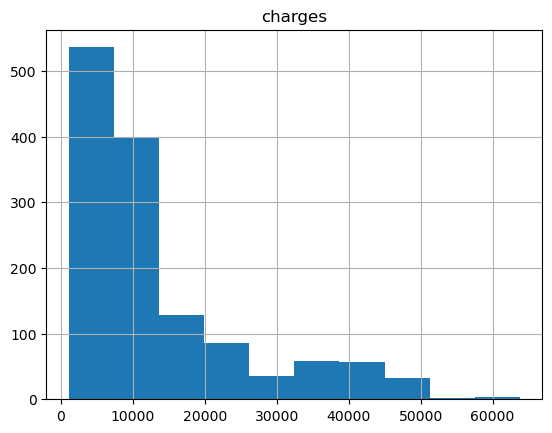

In [51]:
insurance.hist("charges")

OMG. The outcome is skweded. We need to balance the distribution to attenuate the extreme values and reduce the variance.

array([[<AxesSubplot:title={'center':'log_charges'}>]], dtype=object)

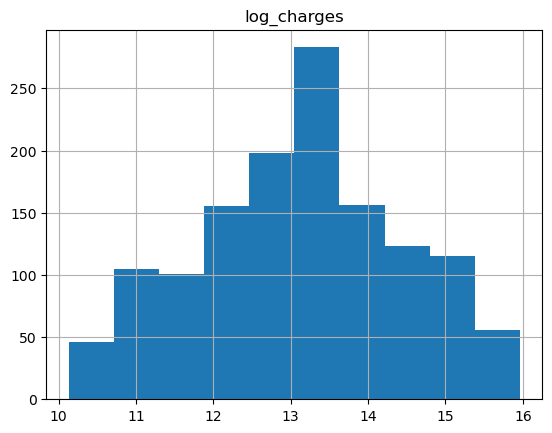

In [43]:
insurance["log_charges"] = np.log2(insurance["charges"])
insurance.hist("log_charges")

That's better !

In [98]:
insurance["log_charges"].describe()

count    1338.000000
mean       13.126590
std         1.326597
min        10.131695
25%        12.210758
50%        13.195685
75%        14.022358
max        15.960600
Name: log_charges, dtype: float64

In [48]:
abs(insurance[["age","bmi", "children", "charges", "log_charges", "sex_male", "smoker_yes", "region_northwest", "region_southeast", "region_southwest"]].corr())

,age,bmi,children,charges,log_charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109272,0.042469,0.299008,0.527834,0.020856,0.025019,0.000407,0.011642,0.010016
bmi,0.109272,1.000000,0.012759,0.198341,0.132669,0.046371,0.003750,0.135996,0.270025,0.006205
children,0.042469,0.012759,1.000000,0.067998,0.161336,0.017163,0.007673,0.024806,0.023066,0.021914
charges,0.299008,0.198341,0.067998,1.000000,0.892964,0.057292,0.787251,0.039905,0.073982,0.043210
log_charges,0.527834,0.132669,0.161336,0.892964,1.000000,0.005632,0.665506,0.017824,0.015791,0.041632
sex_male,0.020856,0.046371,0.017163,0.057292,0.005632,1.000000,0.076185,0.011156,0.017117,0.004184
smoker_yes,0.025019,0.003750,0.007673,0.787251,0.665506,0.076185,1.000000,0.036945,0.068498,0.036945
region_northwest,0.000407,0.135996,0.024806,0.039905,0.017824,0.011156,0.036945,1.000000,0.346265,0.320829
region_southeast,0.011642,0.270025,0.023066,0.073982,0.015791,0.017117,0.068498,0.346265,1.000000,0.346265
region_southwest,0.010016,0.006205,0.021914,0.043210,0.041632,0.004184,0.036945,0.320829,0.346265,1.000000


Regarding the "log_charges" column, it seems that smoker & age have correlations. I'll work with those two features !

In [56]:
features = ["age", "smoker_yes"]

## Spliting The Data

In [66]:
X = insurance[features]
y = insurance["log_charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 727, test_size = 0.2)




In [67]:
print("X_train sshape : ", X_train.shape)
print("X_test sshape : ", X_test.shape)
print("y_train sshape : ", y_train.shape)
print("y_test sshape : ", y_test.shape)

X_train sshape :  (1070, 2)
X_test sshape :  (268, 2)
y_train sshape :  (1070,)
y_test sshape :  (268,)


## Build The Model

Now that I've divided up the data into both a training and test set, I'm ready to build my predictive linear model. After I build the model, I'll take the time to examine the regression coefficients and the coefficient of determination.

In [92]:
model = LinearRegression()
model.fit(X_train, y_train)

coef = model.coef_
intercept = model.intercept_
print("intercept:", intercept)
print("coefficients:", coef)

predictions = model.predict(X_train)
training_mse = mean_squared_error(y_train, predictions)
print("Mean squared error (MSE):", training_mse)
R2 = r2_score(y_train, predictions)
print("Coefficient of determination:", R2)

intercept: 10.583793413957565
coefficients: [0.05254882 2.26404151]
Mean squared error (MSE): 0.41654198485367927
Coefficient of determination: 0.7631964639467459


The MSE of the training set ist 0.42 und the coefficient of determination is 0,763, which is very promising. It indicates that the model can explain 76,3% of the variation in the insurance charges.

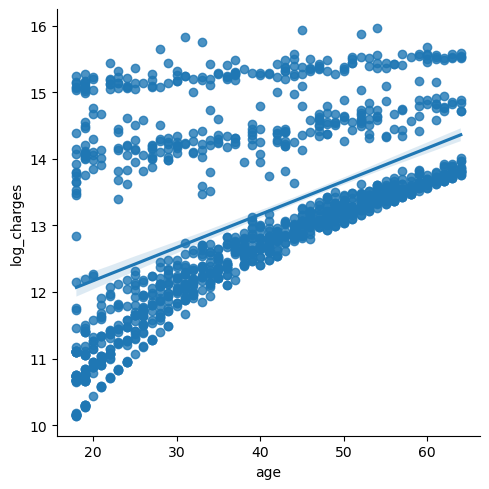

In [84]:
import seaborn as sns
sns.lmplot(x = 'age', y = 'log_charges', data=insurance)

A linear relationship can be seen, but the relationship appears to be bipartite. This may be due to another influencing variable. Since smoking seems to have the biggest impact, we try to show an influence.

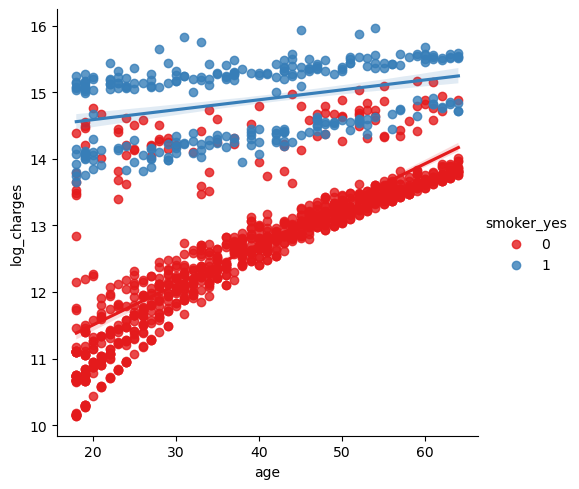

In [87]:
sns.lmplot(x = 'age', y = 'log_charges', data=insurance, hue='smoker_yes', palette='Set1')

The assumption has come true. A linear progression can be seen for both non-smokers and smokers. However, the influence of age seems to be less for smokers, which can be seen from the lower slope of the line.

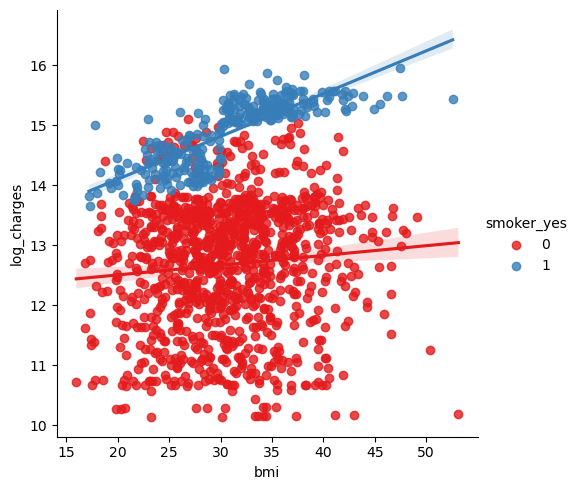

In [90]:
sns.lmplot(x = 'bmi', y = 'log_charges', data=insurance, hue='smoker_yes', palette='Set1')

In fact, BMI does not appear to have a large impact on costs. However, it looks like the combination of high BMI and smoking is particularly bad.

## Residual Diagnostics

In [77]:
residuals = y_train - predictions
print(np.mean(residuals))

3.7021268708995874e-16


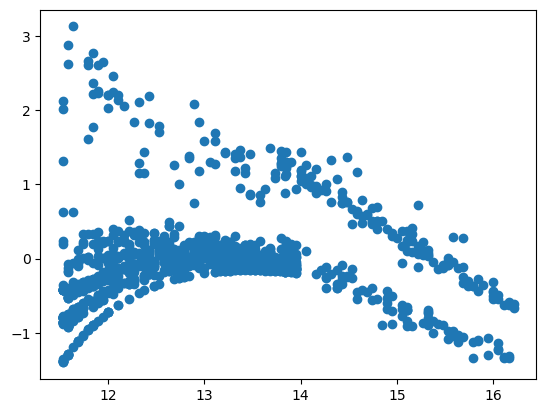

In [76]:
import matplotlib.pyplot as plt
plt.scatter(predictions, residuals)
plt.show()

As fitted values get larger, the residuals trend downward. So the residuals are not perfectly centered in a constant band around zero. Our model seems to have some difficulties at the upper and lower range of values. At the bottom we overestimate the costs and at the top we underestimate them. This does not necessarily make the model predictions unusable, but it puts into question if linear regression is the right model here.

## Final Model Evaluation

In [95]:
test_predictions = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
print("MSE test:", test_mse)

r2_test = r2_score(y_test, test_predictions)
print("Coefficient of determination:", r2_test)

MSE test: 0.6273999528022017
Coefficient of determination: 0.6422926429426381


## Drawing Conclusions

The MSE of the test set (0.63) is higher than the one of the training set (0.49). Since the errors are close, we can conclude that the model is not overfitted. The coefficient of determination is around 64% vs 76%.